# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](../resources/images/gender_bias.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210

# LIGHT *Dataset*

Uma das principais frentes do presente trabalho trata-se da identificação do viés de gênero (*gender bias*) em textos de diálogos entre uma assistente virtual e um usuário. Para realização desse tipo específico de tarefa, tomamos como base o corpora anotado em relação ao gênero criado por [Dinan *et al*. (2020)](https://arxiv.org/pdf/2005.00614.pdf). As principais estatísticas dos corpus estão presentes na tabela abaixo. 

<center>
  <img width="600" src="../resources/images/data_statistics_md_gender_paper.png" />
</center>

[Dinan *et al*. (2020)](https://arxiv.org/pdf/2005.00614.pdf) decompõem a contribuição do gênero ao longo de três dimensões conversacionais para uma classificação mais refinada dos efeitos do gênero em texto de vários domínios. As dimensões, indicadas na tabela pela coluna **Dim**, são:

1. ABOUT (*Speaking About*) - Gênero da pessoa qeu serve de assunto para a conversa
2. TO (*Speaking To*) - Gênero do destinário da conversa, com quem se está falando
3. AS (*Speaking As*) - Gênero de quem está guiando a conversa

<center>
  <img width="600" src="../resources/images/dialogue_gender_bias_md_gender.png"/>
</center>

Como o intuito do nosso trabalho é identificar primordialmente o gênero dos diálogos de assistentes virtuais, não faz muito sentido usarmos essas dimensões.  Portanto, o que consideraremos dos dados anotados serão apenas as classes que indicam o gênero. Neste *notebook*, dos corpus anotados listados na tabela, analisaremos o [LIGHT](https://huggingface.co/datasets/viewer/?dataset=md_gender_bias&config=light_inferred), o qual é constituído de sentenças de diálogos de textos fantasiosos, comumente utilizado para treinamento de agentes em jogos de aventura [[1](https://arxiv.org/pdf/2005.00614.pdf)].

---

### Descrição do LIGHT *Dataset*

- ***Schema* dos dados:**

``` py
  { 
    # Anotação binária
    "binary_label": [ 
      0: "ABOUT:female",
      1: "ABOUT:male"
    ],
    "binary_score": "float32", # Score da anotação binária

    # Anotação considernado o gênero neutro
    "ternary_label": [ 
      0: "ABOUT:female",
      1: "ABOUT:male",
      2: "ABOUT:gender-neutral"
    ],
    "ternary_score": "float32", # Score da anotação ternária
    "text": "string"
  }
```

- **Sumário:** 
> - Possui 245 MB de tamanho
  - Campos do *schema* dos dados
    - `text` - o texto a ser classificado
    - `binary_label` - um rótulo de classificação, com valores possíveis incluindo `ABOUT:female` e `ABOUT:male`
    - `binary_score` - valor que indica uma pontuação entre 0 e 1
    - `ternary_label` - um rótulo de classificação, com valores possíveis incluindo `ABOUT:female`, `ABOUT:male` e `ABOUT:gender-neutral`
    - `ternary_score` - valor que indica uma pontuação entre 0 e 1


# Imports

In [1]:
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '..'
DATASETS_PATH = BASE_PATH + "/resources/datasets"

In [2]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/modules')

import utils

# Leitura dos Dados

Carregando o *dataset* LIGHT do [*HuggingFace*](https://huggingface.co/datasets/viewer/?dataset=md_gender_bias). Aqui todos os processamentos são realizados utilizando o módulo [`Datasets`](https://huggingface.co/docs/datasets) do próprio *HuggingFace*.

In [3]:
dataset = load_dataset('md_gender_bias', 'light_inferred', cache_dir = DATASETS_PATH + "/MDGender")

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset md_gender_bias downloaded and prepared to ../resources/datasets/MDGender/md_gender_bias/light_inferred/1.0.0/01dacda3d3a362db704fa0485596d225bb3790186f7ab7625fa9f81c6402f224. Subsequent calls will reuse this data.


In [4]:
# Enum para as classes
FEMALE, MALE, NEUTRAL = (0, 1, 2)

# Trabalhamos apenas com o conjunto de treino (o único que tem)
train = dataset['train']
pd.DataFrame(train[:5])

,text,binary_label,binary_score,ternary_label,ternary_score
0,hello,0,0.5660,2,0.3920
1,"what brings you here, dear?",0,0.5897,0,0.4741
2,"oh goddess of the forest, we seek thy blessings!",0,0.7413,2,0.5145
3,"time to rest, we can leave the launching point...",1,0.6374,2,0.5910
4,-tweets a song-,0,0.5460,1,0.4366


In [5]:
print('Número de instâncias = {}'.format(len(train)))
print('Número de atributos = {}'.format(len(train.features)))

Número de instâncias = 106122
Número de atributos = 5


Como existem dois tipos de anotação em relação ao gênero (binária e ternário), optou-se por filtrar as sentenças com a mesma classe em ambos os esquemas de anotação ou que foram considerados neutros. A quantidade de sentenças que satisfazem essa restrição ainda é alta.

In [6]:
gender_sureing = train.filter(lambda r: r['binary_label'] == r['ternary_label'] or r['ternary_label'] == NEUTRAL)
df = pd.DataFrame(gender_sureing)
print(f"Número novo de instâncias = {len(gender_sureing)}")

  0%|          | 0/107 [00:00<?, ?ba/s]

Número novo de instâncias = 101197


In [7]:
print('Tipos de cada atributo:\n{}'.format(df.dtypes))

Tipos de cada atributo:
text              object
binary_label       int64
binary_score     float64
ternary_label      int64
ternary_score    float64
dtype: object


In [8]:
print('Valores faltantes em cada coluna:')
for col in df.columns:
  print('{} = {}'.format(col, df[col].isnull().sum()))

Valores faltantes em cada coluna:
text = 0
binary_label = 0
binary_score = 0
ternary_label = 0
ternary_score = 0


In [9]:
dups = df.duplicated()
print('Número de linhas duplicadas = {}'.format(dups.sum()))

Número de linhas duplicadas = 1383


# Análise Explorátória

## Estatísticas de Resumo

Primeiramente, iremos capturar algumas características dos dados ao observar suas estatísticas de resumo. Para visualizar melhor estas estatísticas, exibimos abaixo as informações em formato gráfico ou tabular.

In [10]:
df.describe(include='O')

,text
count,101197
unique,99814
top,hello
freq,279


In [11]:
df.describe()

,binary_label,binary_score,ternary_label,ternary_score
count,101197.000000,101197.000000,101197.000000,101197.000000
mean,0.622726,0.631953,1.530371,0.516376
std,0.484707,0.107142,0.718213,0.121499
min,0.000000,0.500000,0.000000,0.333400
25%,0.000000,0.546100,1.000000,0.418500
50%,1.000000,0.601600,2.000000,0.488900
75%,1.000000,0.696000,2.000000,0.592800
max,1.000000,0.998200,2.000000,0.976800


- **Ocorrências das classes de gênero:**

> Abaixo, podemos ver que as senteças estão bem balanceadas em relação aos gêneros masculino e feminino. Apesar do gênero `neutral` ter bem mais exemplos, isso já era de se esperar.

In [12]:
# Separando as sentenças por gênero
female_sentences = gender_sureing.filter(lambda r: r['ternary_label'] == FEMALE)
male_sentences = gender_sureing.filter(lambda r: r['ternary_label'] == MALE)
neutral_sentences = gender_sureing.filter(lambda r: r['ternary_label'] == NEUTRAL)

  0%|          | 0/102 [00:00<?, ?ba/s]

  0%|          | 0/102 [00:00<?, ?ba/s]

  0%|          | 0/102 [00:00<?, ?ba/s]

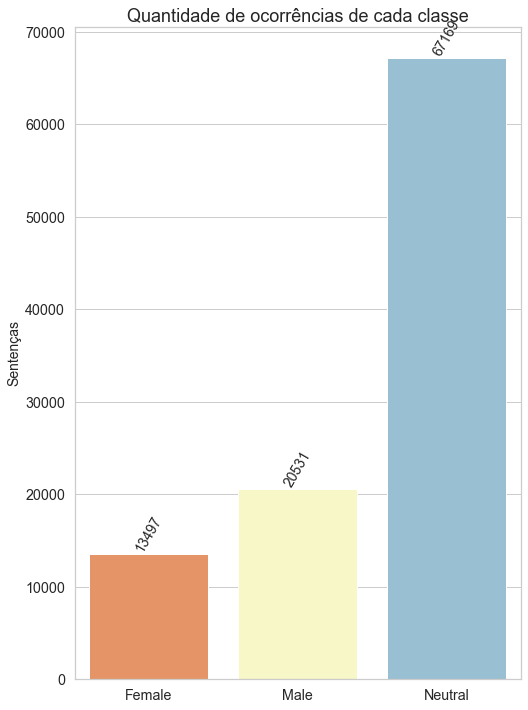

In [13]:
genres_classes = ['Female', 'Male', 'Neutral']
genres_classes_count = [len(female_sentences), len(male_sentences), len(neutral_sentences)]

utils.plot_histogram_labels(x_label=genres_classes, 
                            y_label=genres_classes_count, 
                            labels=genres_classes_count, 
                            palette='RdYlBu',
                            title='Quantidade de ocorrências de cada classe', 
                            ylabel_title='Sentenças', 
                            width=8,
                            height=12)

- **Gráfico de densidades dos *scores* de anotação por gênero:**

> Podemos observar com os gráficos abaixo que a grande maioria das anotações binárias tem *scores* concentrados no `0.5` e `0.8`, já as ternárias tendem a ter um descolamento para baixo, sendo um pouco menores. Acredita-se que, pelos propósitos desta pesquisa e pela utilização prévia no projeto MD*Gender*, estes valores sejam razoáveis.

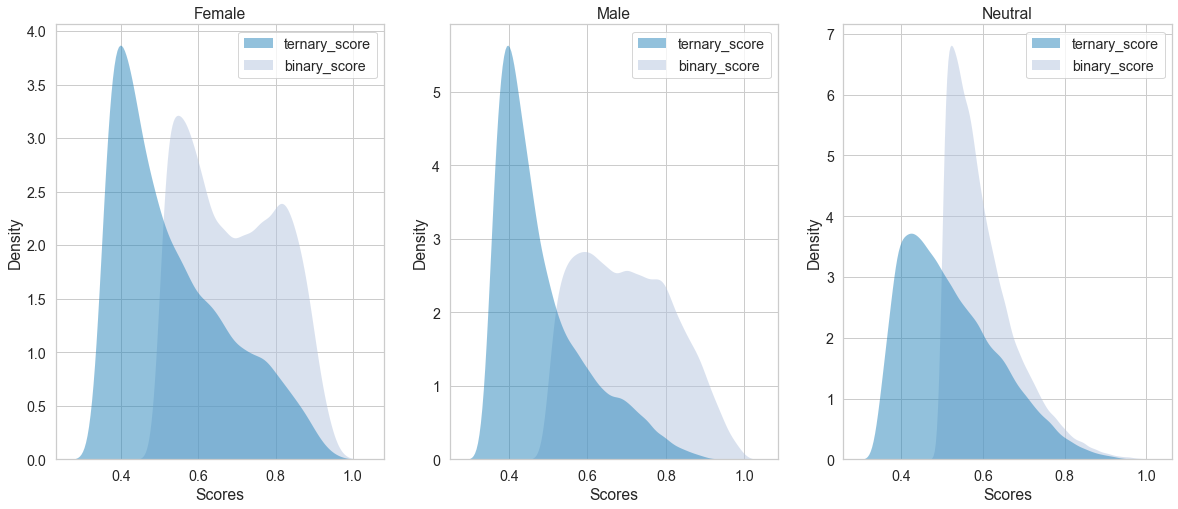

In [14]:
def get_scores(dataset):
  return {
    'ternary_score': dataset['ternary_score'],
    'binary_score': dataset['binary_score']
  }

data = {
  'Female': get_scores(female_sentences),
  'Male': get_scores(male_sentences),
  'Neutral': get_scores(neutral_sentences)
}

utils.plot_densities(data, 'Scores', nrows=1, figsize=(20,8), palette='PuBu_r')

## Quais as palavras mais comuns?

Para sabermos quais as palavras mais comuns presentes nos textos, primeiramente iremos obter algumas estatísticas básicas oriundas do processo de tokenização. Depois, examinaremos quais são as palavras mais comuns através de nuvens de palavras. 

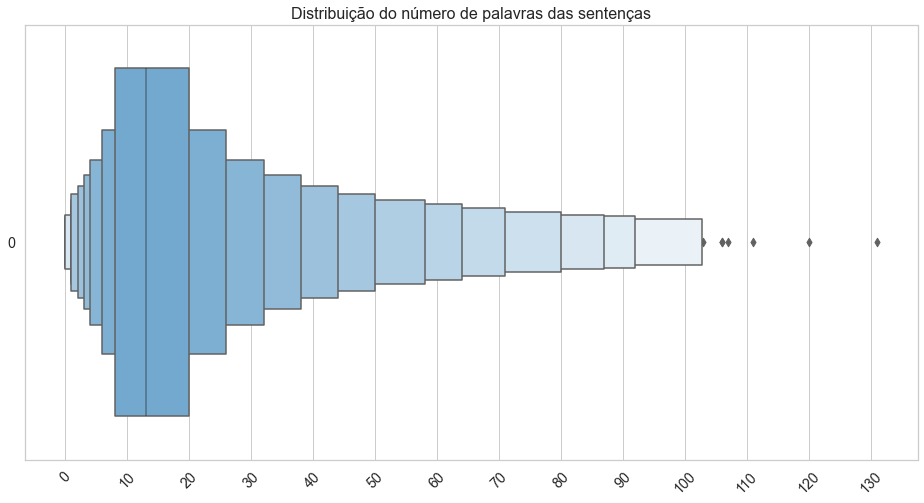

In [15]:
# Tokenização simples e remoção de pontuações, e em lowercase para pegar as stopwords com diferentes formatos
token_count = [len(utils.tokenizer(r['text'])) for r in gender_sureing]

utils.plot_distribution_large_data(token_count, 
                                   title='Distribuição do número de palavras das sentenças', 
                                   xaxis_interval=10)

Observe que o gráfico acima exibe a quantidade de palavras dos textos dos diálogos. A grande maioria está concentrada no intervalo de 6 a 13 palavras, ou seja, o LIGHT *dataset* possui muitos textos curtos, com apenas uma ou duas frases.

Além disso, existem 1.239 sentenças com apenas um *token*, muito provavelmente inúteis para nosso objetivo. Logo, serão removidos na etapa de pré-processamento, então, guardaremos esta informação para o futuro. Seguem alguns exemplos:



In [16]:
small_sentences = gender_sureing.filter(lambda r: len(utils.tokenizer(r['text'])) == 1)
print('\nQuantidade de sentenças com apenas um token = {}\nExemplos de sentenças ='.format(len(small_sentences)))
small_sentences['text'][0:20]

  0%|          | 0/102 [00:00<?, ?ba/s]


Quantidade de sentenças com apenas um token = 1239
Exemplos de sentenças =


['hello',
 'hello',
 'hello',
 'hello..',
 'hello',
 'oooooooooooooo',
 'meow!',
 'hello',
 'meow!',
 'hello',
 'bak-bak-baaak',
 'grrrrr',
 'hello',
 'hello',
 'hi',
 'hi',
 'hi',
 'hi',
 'hello',
 'hello']

E, como era de se esperar de um dado textual, as nuvens de palavras abaixo nos mostra o que já explicamos no 1º *notebook* de análise exploratória do *Wikipedia Toxic Comments dataset*.

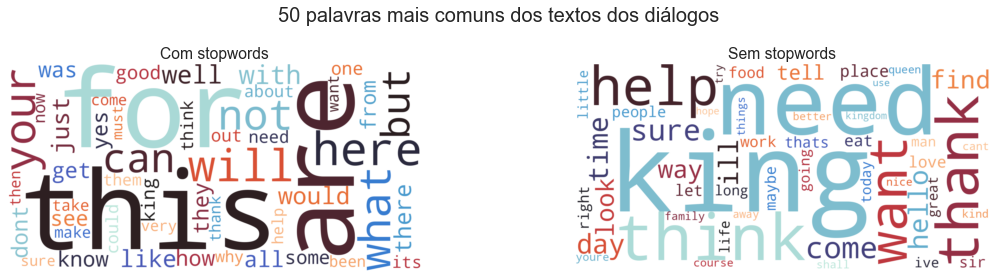

In [17]:
words_clean_count = utils.count_tokens(gender_sureing['text'])
words_count = utils.count_tokens(gender_sureing['text'], remove_stopwords=False)

general_word_counts = {
   'Com stopwords': words_count,
   'Sem stopwords': words_clean_count
}
utils.plot_word_clouds(general_word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos', 
                       figsize=(16, 4))

## Quais são as palavras mais comuns por gênero?

A partir do gráfico de distribuição abaixo, é possível notar que a grande maioria das palavras ocorrem com frequência menor ou igual a 1500.

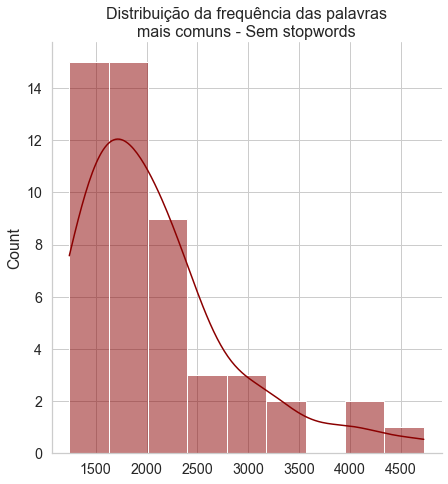

In [18]:
most_common_tokens = Counter(words_clean_count)

sns.set(style='whitegrid', font_scale=1.3)
sns.displot(data=[tup[1] for tup in most_common_tokens.items()], kde=True, color='darkred', height=6.5)
plt.title('Distribuição da frequência das palavras\nmais comuns - Sem stopwords', fontsize=16)
plt.show()

Com isso, para uma melhor análise das palavras mais relevantes de cada gênero, optamos por ignorar as palavras que ocorrem mais do que 1500 vezes. Essa escolha é denotada pela linha vermelha traçada no gráfico abaixo: 

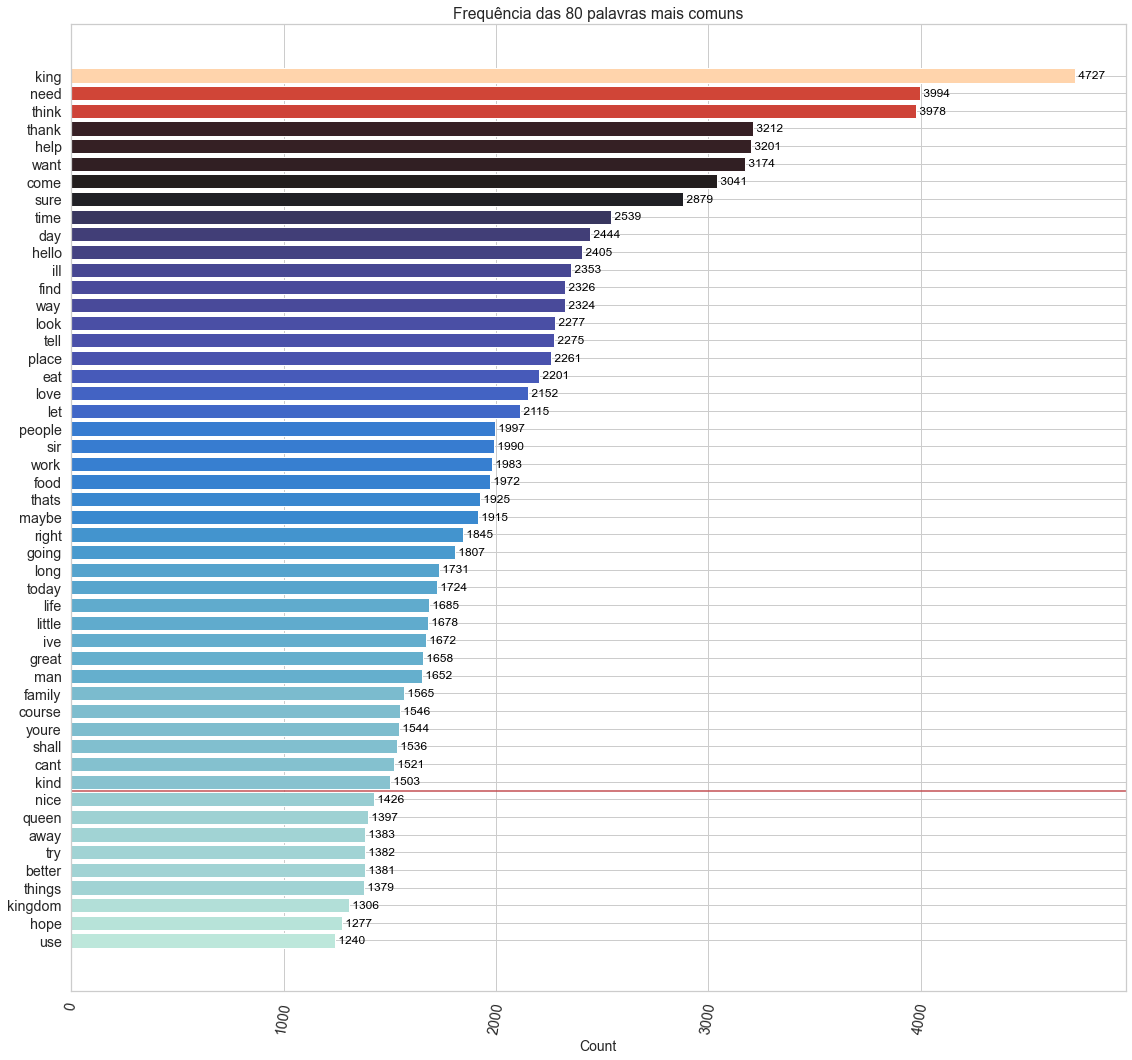

In [19]:
plt.figure(figsize=(16, 15))
utils.plot_most_frequent_elements(most_common_tokens, 
                                  n_most_common=80, 
                                  title='Frequência das 80 palavras mais comuns')
plt.axhline(y=8.46, color='r', linestyle='-');

In [20]:
words2ignore = [tup[0] for tup in most_common_tokens.items() if tup[1] > 1500]

female_words_count = utils.count_tokens(female_sentences['text'], n_most_common=50, to_ignore=words2ignore)
male_words_count = utils.count_tokens(male_sentences['text'], n_most_common=50, to_ignore=words2ignore)
neutral_words_count = utils.count_tokens(neutral_sentences['text'], n_most_common=50, to_ignore=words2ignore)

print('Quantidade de palavras que devem ser ignoradas = {}'.format(len(words2ignore)))

Quantidade de palavras que devem ser ignoradas = 41


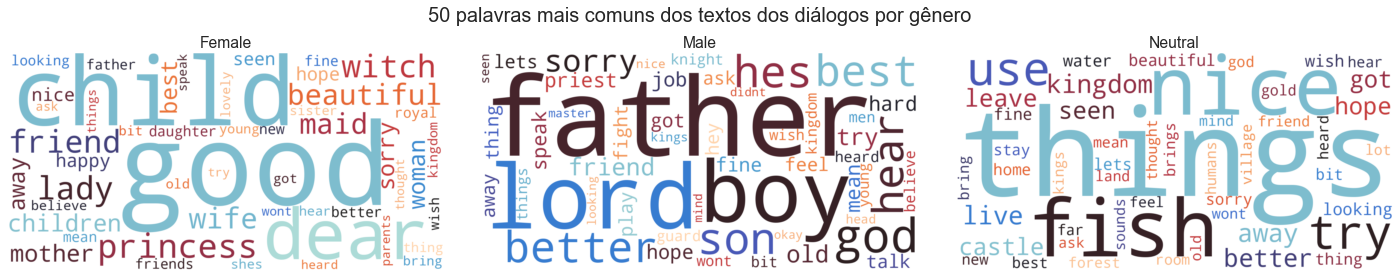

In [21]:
word_counts = {
   'Female': female_words_count,
   'Male': male_words_count,
   'Neutral': neutral_words_count
}

utils.plot_word_clouds(word_counts, 
                       title='50 palavras mais comuns dos textos dos diálogos por gênero',
                       figsize=(20, 4))

Advertimos que o termo "viés" é frequentemente usado para se referir a disparidades em sistemas algorítmicos que são questionáveis por razões sociais. Aqui, restringimos o uso de preconceito à sua definição tradicional. 

O processo de anotação de gênero no ConvAI2 foi feito automaticamente por um modelo que já possui um viés oriundo dos dados usados para o seu treinamento. Por isso que alguns termos ilustrativamente conhecidos como de um determinado gênero têm maior destaque nas nuvens de palavras acima. Isso não necessariamente é ruim para o nosso objetivo. No entanto, pode ser ruim em outros contextos, os quais nós estamos justamente tentando evitar através desta análise.

Gostaríamos de deixar claro que reconhecemos plenamente a existência e a importância de todas as identidades de gênero. Temos como objetivo final alcançar um acessível, inclusivo e justo sistema de NLP. No entanto, esses tópicos requerem uma investigação mais sutil do que seria viável, além do que, infelizmente, o cenário de viés de gênero para assistentes virtuais é preconceituoso e bastante binário (gêneros femininos ou masculinos).

## Qual a quantidade de palavras ofensivas nos textos dos diálogos por gênero?

Aqui, tal como também foi feito no 1º *notebook* de EDA [[2](https://github.com/barbaraneves/gender-bias-in-virtual-assistants/blob/main/exploratory-data-analysis/1%20-%20Wikipedia%20Toxic%20Comments%20Dataset%20Analysis.ipynb)], verificamos a presença de palavras ofensivas e de baixo calão com base no *List of Dirty, Naughty, Obscene, and Otherwise Bad Words* [[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)]. No entanto, verificando as nuvens de palavras por gênero, podemos dizer antecipadamente que estes termos não são tão frequentes. 

In [22]:
def add_count(r):
  r['bad_words'] = utils.count_bad_words(r['text'])
  return r

male_bad_sentences = male_sentences.map(add_count).filter(lambda r: r['bad_words'] > 0)
female_bad_sentences = female_sentences.map(add_count).filter(lambda r: r['bad_words'] > 0)
neutral_bad_sentences = neutral_sentences.map(add_count).filter(lambda r: r['bad_words'] > 0)

  0%|          | 0/20531 [00:00<?, ?ex/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/13497 [00:00<?, ?ex/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/67169 [00:00<?, ?ex/s]

  0%|          | 0/68 [00:00<?, ?ba/s]

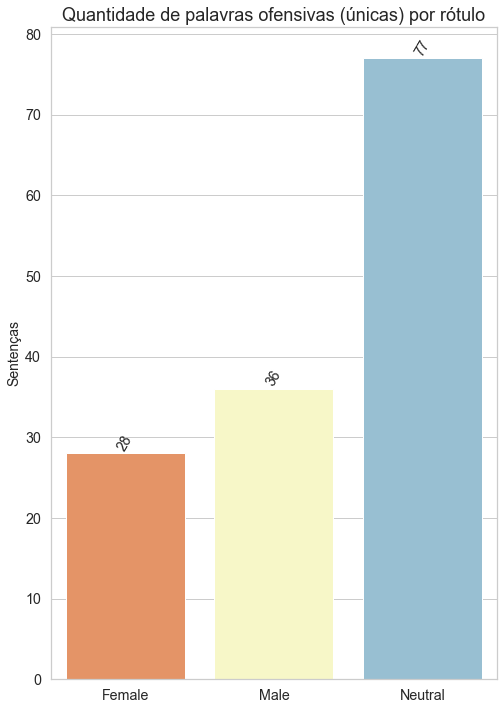

In [23]:
bad_words_per_class = [
                       sum(female_bad_sentences['bad_words']),
                       sum(male_bad_sentences['bad_words']),
                       sum(neutral_bad_sentences['bad_words'])
]

utils.plot_histogram_labels(x_label=genres_classes, 
                            y_label=bad_words_per_class, 
                            labels=bad_words_per_class, 
                            palette='RdYlBu',
                            title='Quantidade de palavras ofensivas (únicas) por rótulo', 
                            ylabel_title='Sentenças', 
                            width=8,
                            height=12)

Nota-se que a distribuição das palavras ofensivas nos gêneros segue a própria distribuição dos dados. No entanto, após uma rápida análise, é possível perceber que as expressões em que essas palavras estão presentes, em sua grande maioria, não denotam caráter ofensivo quando contextualizadas. Seguem alguns exemplos:

In [24]:
neutral_bad_sentences['text'][:10]

["this place really sucks, i'm glad i saved this moldy breaf for later",
 'is that what that is?  it passes through the digestive system very quickly.  it speckles my scat.',
 'i most certainly am, it sucks living in a cave!',
 'wait, what?!? i’m not an ass! or even a donkey! i’m a man! what is this place?',
 '*poof* you have now been cursed with the spell of frozen time and life. you have attempted to do me wrong, and now you will sit in my shop aware of everything going on for the rest of your life. no one can undo the spell, but i. ',
 'thank you. if you wish to see more, i could escort you to the observation deck. it is a view that cannot be described.',
 'i see then! no need to pout! your wish is my command! and poof! just like that, your alloys will never decay!',
 'you try to suck my blood and give me disease, am i not justified?',
 'it really sucks, this could have been our home.',
 'i breathe through my butt for some reason']

# Referências

[[1](https://arxiv.org/pdf/2005.00614.pdf)] Dinan, E., Fan, A., Wu, L., Weston, J., Kiela, D. and Williams, A., 2020. Multi-dimensional Gender Bias Classification. *arXiv preprint arXiv:2005.00614*.

[[2](https://github.com/barbaraneves/gender-bias-in-virtual-assistants/blob/main/exploratory-data-analysis/1%20-%20Wikipedia%20Toxic%20Comments%20Dataset%20Analysis.ipynb)] 1 - Wikipedia Toxic Comments Dataset Analysis.

[[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)] Our List of Dirty, Naughty, Obscene, and Otherwise Bad Words. 2020. *GitHub*. LDNOOBW.